##### Import Necessary Packages

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import friedmanchisquare, wilcoxon

from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import wittgenstein as lw

##### Configuration

In [ ]:
RESULTS_DIR = "../../temp_results/"
SAVE_DIR = "../../temp_results/grouped"

FOLDERS = ["AM", "MOEAAM", "MOEAAM_RS"]
OBJECTIVES = ["spec_sens", "conf_simp", "conf_spec", "conf_sens"]

DATASETS = [
    "mushrooms", "tictactoe", "hepatitis", "ljubljana", "cargood",
    "chess", "zoo3", "flare", "yeast3", "abalone19", "segment0", "pageblocks"
]

TARGET_METRICS = [
    "accuracy", "f1_score", "recall", "precision", "specificity", 
    "nb_rules", "term_rule_ratio", "hypervolume"
]

##### Results Aggregation

In [43]:
def process_results():
    dataset_results = {}

    for dataset in DATASETS:
        mean_rows = []
        std_rows = []
        
        for folder in FOLDERS:
            for obj in OBJECTIVES:
                file_path = os.path.join(RESULTS_DIR, folder, f"{dataset}_{obj}.csv")
                
                if not os.path.exists(file_path):
                    continue
                
                try:
                    df = pd.read_csv(file_path)
                    
                    # Normalization
                    if 'accuracy' in df.columns and df['accuracy'].dropna().max() <= 1.0001:
                        cols_to_scale = ["accuracy", "f1_score", "recall", "precision", "specificity"]
                        for col in cols_to_scale:
                            if col in df.columns:
                                df[col] = df[col] * 100
                    
                    # Mean and Std grouped by Split
                    numeric_cols = df.select_dtypes(include='number').columns
                    means_by_split = df.groupby('split')[numeric_cols].mean().round(3)
                    stds_by_split = df.groupby('split')[numeric_cols].std().round(3)
                    
                    
                    for split in ['train', 'test']:
                        if split in means_by_split.index:
                            
                            
                            base_info = {
                                "Algorithm": folder,
                                "Objective": obj,
                                "Split": split
                            }
                            
                            row_mean = base_info.copy()
                            row_std = base_info.copy()
                            
                            for metric in TARGET_METRICS:
                                if metric in means_by_split.columns:
                                    row_mean[metric] = means_by_split.loc[split, metric]
                                else:
                                    row_mean[metric] = None
                                
                                if metric in stds_by_split.columns:
                                    row_std[metric] = stds_by_split.loc[split, metric]
                                else:
                                    row_std[metric] = None
                            
                            mean_rows.append(row_mean)
                            std_rows.append(row_std)

                except Exception as e:
                    print(f"Error processing {file_path}: {e}")

        # Create DataFrames
        dataset_results[dataset] = {}
        
        if mean_rows:
            # Mean DataFrame
            df_mean = pd.DataFrame(mean_rows)
            df_mean.set_index(["Algorithm", "Objective", "Split"], inplace=True)
            dataset_results[dataset]['mean'] = df_mean
            
            # Std DataFrame
            df_std = pd.DataFrame(std_rows)
            df_std.set_index(["Algorithm", "Objective", "Split"], inplace=True)
            dataset_results[dataset]['std'] = df_std
        else:
            dataset_results[dataset]['mean'] = pd.DataFrame()
            dataset_results[dataset]['std'] = pd.DataFrame()

    return dataset_results

dfs = process_results()

In [44]:
for dataset, df in dfs.items():
    df['mean'].to_csv(os.path.join(SAVE_DIR, f"{dataset}_mean.csv"))
    df['std'].to_csv(os.path.join(SAVE_DIR, f"{dataset}_std.csv"))

##### Generalization 

In [45]:
sns.set_theme(style="whitegrid")

def plot_generalization_gap(results, datasets, metric="f1_score"):

    # Configuration
    colors = {'train': '#1f77b4', 'test': '#d62728', 'line': '#7f7f7f'}
    obj_map = {
        "spec_sens": "sp,se", "conf_simp": "conf,si", 
        "conf_spec": "conf,sp", "conf_sens": "conf,se"
    }
    
    fig, axes = plt.subplots(4, 3, figsize=(26, 20))
    axes_flat = axes.flatten()

    for i, ax in enumerate(axes_flat):
        if i >= len(datasets):
            ax.axis('off')
            continue
            
        ds_name = datasets[i]
        
        if ds_name not in results or 'mean' not in results[ds_name]:
            continue

        df = results[ds_name]['mean'].reset_index().copy()
        
        if metric not in df.columns:
            continue

        df['Label'] = df.apply(
            lambda x: f"{x['Algorithm']} ({obj_map.get(x['Objective'], x['Objective'])})", 
            axis=1
        )
        
        df_viz = df.pivot(index='Label', columns='Split', values=metric)
        if 'test' in df_viz.columns:
            df_viz = df_viz.sort_values(by='test', ascending=True)

        ax.hlines(y=df_viz.index, xmin=df_viz['test'], xmax=df_viz['train'], 
                  color=colors['line'], alpha=0.5, linewidth=3, zorder=1)
        
        ax.scatter(df_viz['train'], df_viz.index, color=colors['train'], s=80, zorder=2, label='Train' if i == 0 else "")
        ax.scatter(df_viz['test'], df_viz.index, color=colors['test'], s=80, zorder=2, label='Test' if i == 0 else "")

        for idx, label in enumerate(df_viz.index):
            train_val = df_viz.loc[label, 'train']
            test_val = df_viz.loc[label, 'test']
            
            ax.text(train_val, idx + 0.15, f"{train_val:.1f}", 
                    ha='center', va='bottom', fontsize=9, color=colors['train'], fontweight='bold')

            is_close = abs(train_val - test_val) < 2.0
            test_va = 'top' if is_close else 'bottom'
            test_offset = -0.15 if is_close else 0.15

            ax.text(test_val, idx + test_offset, f"{test_val:.1f}", 
                    ha='center', va=test_va, fontsize=9, color=colors['test'], fontweight='bold')

        ax.set_title(ds_name.capitalize(), fontsize=12, fontweight='bold')
        ax.tick_params(axis='y', labelsize=10)
        ax.set_ylabel("")
        ax.set_xlabel("")
        ax.set_xlim(50, 103)

    handles, labels = axes_flat[0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=14, bbox_to_anchor=(0.5, 0.99))

    fig.suptitle(f"Generalization Gap ({metric.replace('_', ' ').capitalize()})", fontsize=18, y=1.0)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

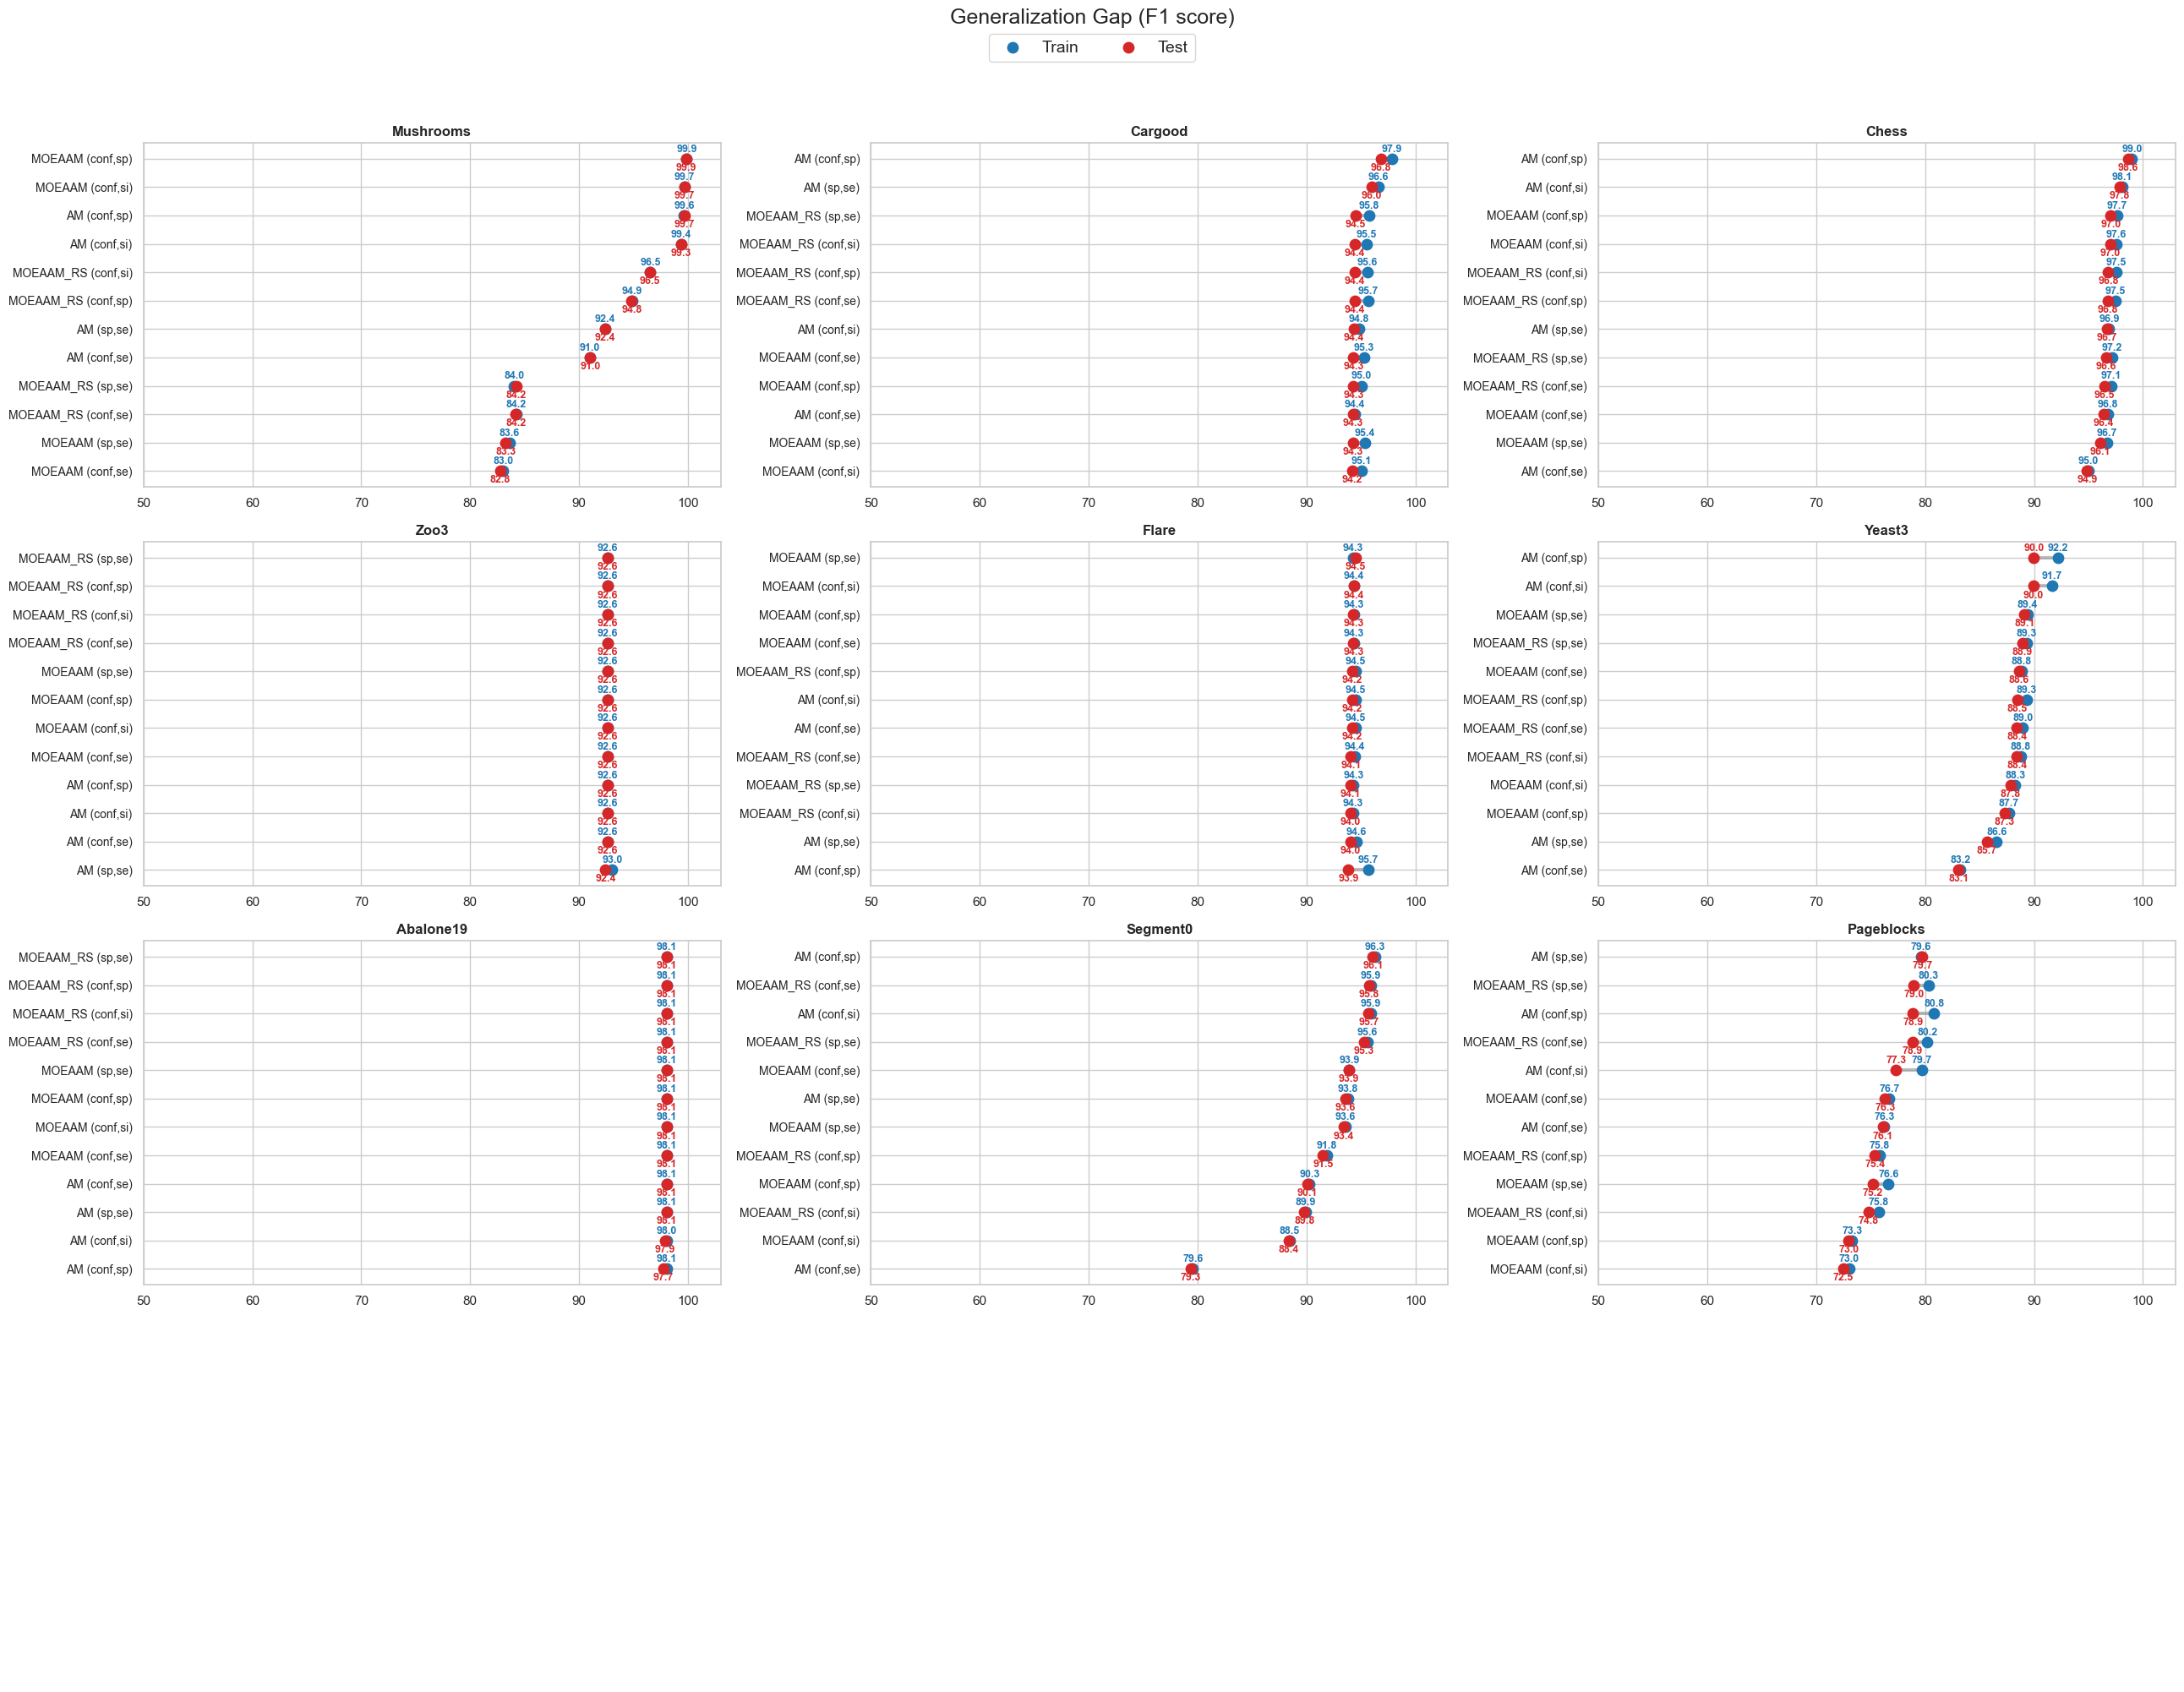

In [46]:
plot_generalization_gap(dfs, DATASETS, metric="f1_score")

##### Results Ranking

In [47]:
def get_ranking_df(df_values):

    df_ranks = df_values.rank(axis=1, ascending=False, method='average')
    avg_ranks = df_ranks.mean(axis=0)
    df_ranks.loc['Average Rank'] = avg_ranks
    df_ranks= df_ranks.map(lambda x: f'{x:g}')
    
    return df_ranks

def get_ranking(df_values):
    ranks = df_values.rank(axis=1, ascending=False, method='average')
    df_out = df_values.map('{:g}'.format) + " (" + ranks.map('{:g}'.format) + ")"
    df_out.loc['Average Rank'] = ranks.mean().map('{:.4g}'.format)

    return df_out, ranks.mean()

def plot_avg_ranks(avg_ranks, metric_name):
    sorted_avg_ranks = avg_ranks.sort_values()
    plt.figure(figsize=(12, 6))
    sorted_avg_ranks.plot(kind='barh', color='lightgrey')
    plt.title(f'Average Rank of Each Variant for {metric_name}')
    plt.xlabel('Mean Rank')
    
    plt.axvline(x=sorted_avg_ranks.mean(), color='red', linestyle='--', label='Global Average')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [48]:
def extract_means(results_data, target_metric="accuracy"):
    friedman_dict = {}

    for folder in FOLDERS:
        for obj in OBJECTIVES:
            
            dict_key = f"{folder}({obj})"    
            scores_list = []
            
            for dataset in DATASETS:
                if dataset not in results_data or 'mean' not in results_data[dataset]:
                    scores_list.append(None)
                    continue
                
                df_mean = results_data[dataset]['mean']
                
                if df_mean.empty:
                    scores_list.append(None)
                    continue
                
                try:
                    val = df_mean.loc[(folder, obj, 'test'), target_metric]
                    scores_list.append(round(val, 2))
                    
                except KeyError:
                    scores_list.append(None)
            
            friedman_dict[dict_key] = scores_list

    return friedman_dict

def extract_specific_means(results_data, combinations, target_metric="accuracy"):
    friedman_dict = {}

    for algo, obj in combinations:
        
        dict_key = f"{algo}({obj})"
        scores_list = []
        
        for dataset in DATASETS:
            if dataset not in results_data or 'mean' not in results_data[dataset]:
                scores_list.append(None)
                continue
            
            df_mean = results_data[dataset]['mean']
            
            if df_mean.empty:
                scores_list.append(None)
                continue
            
            try:
                val = df_mean.loc[(algo, obj, 'test'), target_metric]
                scores_list.append(round(val, 2))
                
            except KeyError:
                scores_list.append(None)
        
        friedman_dict[dict_key] = scores_list

    return friedman_dict

1. ACCURACY

In [49]:
accuracy_dict = extract_means(dfs, target_metric="accuracy")

accuracy_df = pd.DataFrame(accuracy_dict, index=DATASETS)
accuracy_ranks, accuracy_avg_ranks = get_ranking(accuracy_df)
accuracy_ranks

,AM(spec_sens),AM(conf_simp),AM(conf_spec),AM(conf_sens),MOEAAM(spec_sens),MOEAAM(conf_simp),MOEAAM(conf_spec),MOEAAM(conf_sens),MOEAAM_RS(spec_sens),MOEAAM_RS(conf_simp),MOEAAM_RS(conf_spec),MOEAAM_RS(conf_sens)
mushrooms,92.47 (7),99.34 (4),99.66 (3),91.19 (8),83.69 (11),99.7 (2),99.86 (1),83.22 (12),84.71 (9),96.52 (5),94.86 (6),84.53 (10)
cargood,96.06 (2),95.97 (4),97.13 (1),96.01 (3),95.7 (8),95.81 (5),95.73 (7),95.76 (6),95.57 (11),95.6 (10),95.68 (9),95.45 (12)
chess,96.46 (9),98.09 (2),98.68 (1),96.22 (11),96.08 (12),97.64 (3.5),97.64 (3.5),96.67 (7),96.57 (8),97.3 (5.5),97.3 (5.5),96.24 (10)
zoo3,94.65 (12),95.05 (6),95.05 (6),95.05 (6),95.05 (6),95.05 (6),95.05 (6),95.05 (6),95.05 (6),95.05 (6),95.05 (6),95.05 (6)
flare,94.16 (12),95.55 (9),94.48 (11),95.52 (10),96.15 (1),95.97 (4),96.02 (2.5),96.02 (2.5),95.8 (6),95.85 (5),95.74 (7),95.7 (8)
yeast3,88.02 (12),90.3 (2),90.56 (1),88.06 (11),90.11 (3),89.73 (8),89.64 (9),90.08 (4),90.01 (5),89.9 (6),89.61 (10),89.78 (7)
abalone19,98.7 (5.5),98.32 (11),97.96 (12),98.7 (5.5),98.7 (5.5),98.7 (5.5),98.7 (5.5),98.7 (5.5),98.7 (5.5),98.7 (5.5),98.7 (5.5),98.7 (5.5)
segment0,93.59 (7),95.99 (2),96.19 (1),85.2 (12),93.79 (6),90.51 (11),91.61 (9),94.16 (5),95.36 (4),91.43 (10),92.64 (8),95.8 (3)
pageblocks,82.9 (1),80.19 (11),80.95 (8),81.81 (4),80.77 (9),80.09 (12),80.29 (10),81.37 (5),82.52 (3),81.03 (7),81.31 (6),82.58 (2)
Average Rank,7.5,5.667,4.889,7.833,6.833,6.333,5.944,5.889,6.389,6.667,7,7.056


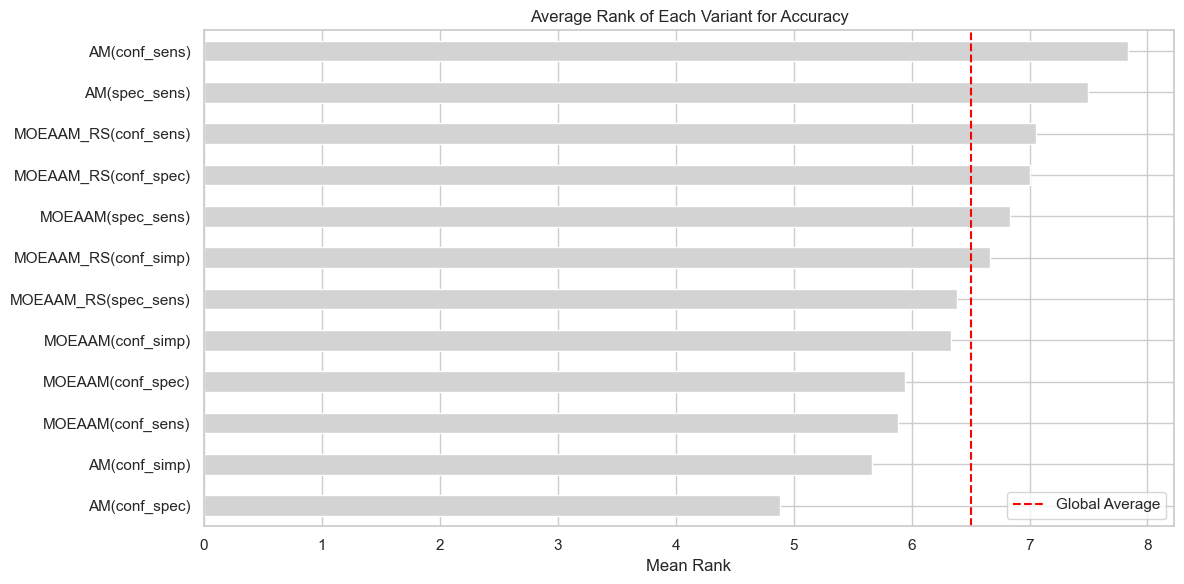

In [50]:
plot_avg_ranks(accuracy_avg_ranks, "Accuracy")

2. F1-SCORE

In [51]:
f1_dict = extract_means(dfs, target_metric="f1_score")

f1_df = pd.DataFrame(f1_dict, index=DATASETS)
f1_ranks, f1_avg_ranks = get_ranking(f1_df)
f1_ranks

,AM(spec_sens),AM(conf_simp),AM(conf_spec),AM(conf_sens),MOEAAM(spec_sens),MOEAAM(conf_simp),MOEAAM(conf_spec),MOEAAM(conf_sens),MOEAAM_RS(spec_sens),MOEAAM_RS(conf_simp),MOEAAM_RS(conf_spec),MOEAAM_RS(conf_sens)
mushrooms,92.41 (7),99.34 (4),99.66 (3),91.03 (8),83.26 (11),99.7 (2),99.86 (1),82.76 (12),84.21 (9),96.51 (5),94.82 (6),84.19 (10)
cargood,95.99 (2),94.37 (7),96.84 (1),94.29 (10),94.26 (11),94.17 (12),94.3 (9),94.31 (8),94.53 (3),94.43 (4),94.42 (5.5),94.42 (5.5)
chess,96.71 (7),97.84 (2),98.63 (1),94.89 (12),96.08 (11),97.01 (4),97.04 (3),96.37 (10),96.65 (8),96.83 (5),96.77 (6),96.47 (9)
zoo3,92.43 (12),92.63 (6),92.63 (6),92.63 (6),92.63 (6),92.63 (6),92.63 (6),92.63 (6),92.63 (6),92.63 (6),92.63 (6),92.63 (6)
flare,94.02 (11),94.19 (6),93.85 (12),94.17 (7),94.51 (1),94.36 (2),94.32 (3),94.31 (4),94.05 (9),94.04 (10),94.22 (5),94.08 (8)
yeast3,85.66 (11),89.96 (2),89.99 (1),83.09 (12),89.14 (3),87.84 (9),87.31 (10),88.63 (5),88.92 (4),88.41 (8),88.45 (6),88.42 (7)
abalone19,98.06 (5.5),97.9 (11),97.74 (12),98.06 (5.5),98.06 (5.5),98.06 (5.5),98.06 (5.5),98.06 (5.5),98.06 (5.5),98.06 (5.5),98.06 (5.5),98.06 (5.5)
segment0,93.57 (6),95.7 (3),96.09 (1),79.34 (12),93.45 (7),88.36 (11),90.06 (9),93.92 (5),95.3 (4),89.79 (10),91.52 (8),95.76 (2)
pageblocks,79.73 (1),77.34 (5),78.87 (3.5),76.15 (7),75.18 (9),72.49 (12),73 (11),76.31 (6),78.97 (2),74.81 (10),75.38 (8),78.87 (3.5)
Average Rank,6.944,5.111,4.5,8.833,7.167,7.056,6.389,6.833,5.611,7.056,6.222,6.278


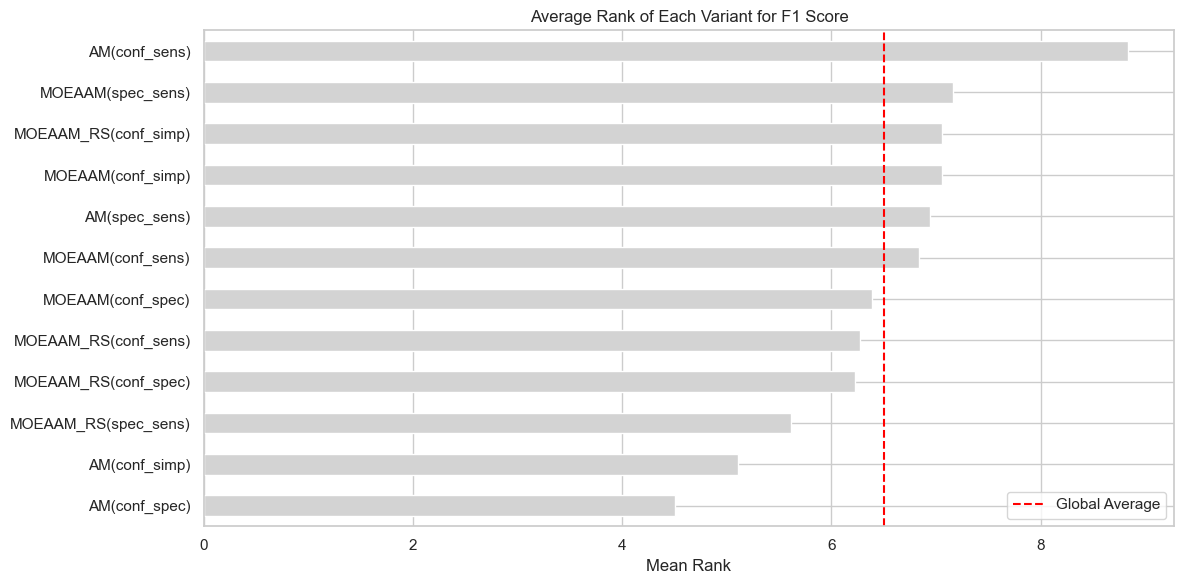

In [52]:
plot_avg_ranks(f1_avg_ranks, "F1 Score")

3. PRECISION

In [53]:
precision_dict = extract_means(dfs, target_metric="precision")

precision_df = pd.DataFrame(precision_dict, index=DATASETS)
precision_ranks, precision_avg_ranks = get_ranking(precision_df)
precision_ranks

,AM(spec_sens),AM(conf_simp),AM(conf_spec),AM(conf_sens),MOEAAM(spec_sens),MOEAAM(conf_simp),MOEAAM(conf_spec),MOEAAM(conf_sens),MOEAAM_RS(spec_sens),MOEAAM_RS(conf_simp),MOEAAM_RS(conf_spec),MOEAAM_RS(conf_sens)
mushrooms,93.26 (7),99.36 (4),99.67 (3),92.5 (8),86.28 (11.5),99.71 (2),99.86 (1),86.28 (11.5),87.81 (9),96.76 (5),95.37 (6),87.6 (10)
cargood,96.26 (2),93.51 (10),96.76 (1),93.16 (12),93.53 (9),93.28 (11),93.7 (8),93.84 (6),93.91 (3),93.88 (5),93.82 (7),93.89 (4)
chess,97.11 (7),97.99 (2),98.66 (1),93.69 (12),96.61 (10),97.7 (3.5),97.7 (3.5),96.56 (11),96.99 (9),97.28 (6),97.29 (5),97.04 (8)
zoo3,90.32 (12),90.34 (6),90.34 (6),90.34 (6),90.34 (6),90.34 (6),90.34 (6),90.34 (6),90.34 (6),90.34 (6),90.34 (6),90.34 (6)
flare,93.95 (1),93.37 (3),93.51 (2),93.22 (4),93.06 (5),93 (6),92.89 (8),92.9 (7),92.42 (11),92.36 (12),92.87 (9),92.67 (10)
yeast3,84.48 (11),89.94 (1),89.93 (2),78.77 (12),88.92 (3),87.46 (10),87.97 (9),88.52 (5),88.67 (4),88.08 (8),88.22 (7),88.28 (6)
abalone19,97.43 (7.5),97.47 (2),97.55 (1),97.43 (7.5),97.43 (7.5),97.43 (7.5),97.43 (7.5),97.43 (7.5),97.43 (7.5),97.43 (7.5),97.43 (7.5),97.43 (7.5)
segment0,93.86 (6),95.56 (3),96.37 (1),75.44 (12),93.63 (7),91.39 (11),92.21 (9),93.95 (5),95.38 (4),91.99 (10),93.02 (8),95.86 (2)
pageblocks,80.99 (5),78.77 (11),79.92 (8.5),79.92 (8.5),79.32 (10),76.7 (12),80.52 (7),80.94 (6),81.56 (3),81.19 (4),81.61 (2),81.9 (1)
Average Rank,6.5,4.667,2.833,9.111,7.667,7.667,6.556,7.222,6.278,7.056,6.389,6.056


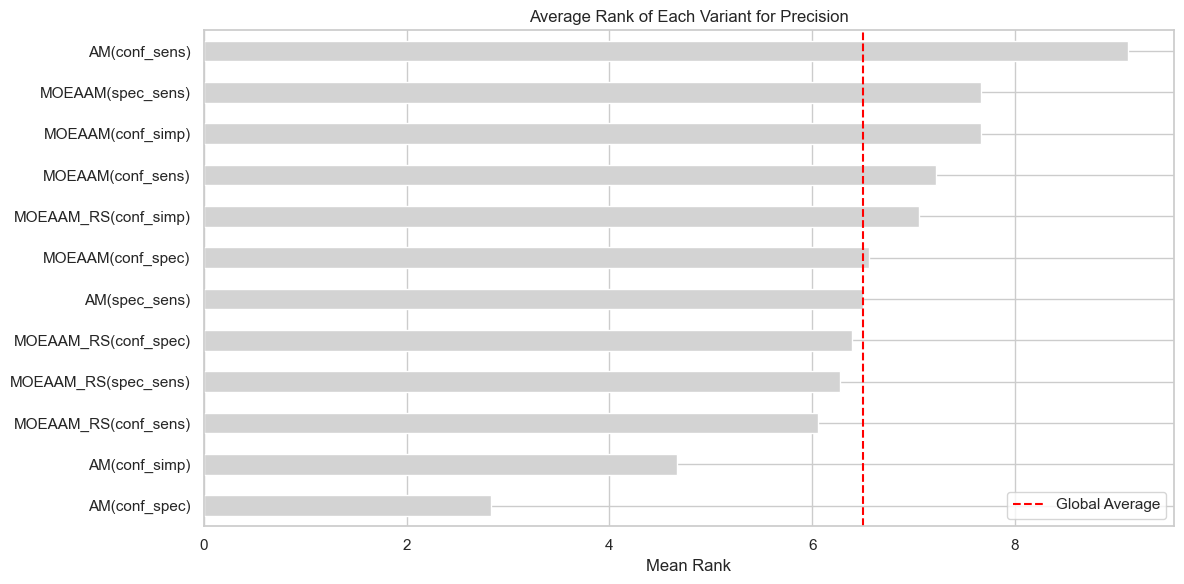

In [54]:
plot_avg_ranks(precision_avg_ranks, "Precision")

4. SPECIFICITY

In [55]:
specificity_dict = extract_means(dfs, target_metric="specificity")

specificity_df = pd.DataFrame(specificity_dict, index=DATASETS)
specificity_ranks, specificity_avg_ranks = get_ranking(specificity_df)
specificity_ranks

,AM(spec_sens),AM(conf_simp),AM(conf_spec),AM(conf_sens),MOEAAM(spec_sens),MOEAAM(conf_simp),MOEAAM(conf_spec),MOEAAM(conf_sens),MOEAAM_RS(spec_sens),MOEAAM_RS(conf_simp),MOEAAM_RS(conf_spec),MOEAAM_RS(conf_sens)
mushrooms,96.97 (8),99.82 (5.5),99.9 (4),97.58 (7),81.58 (9),100 (2),100 (2),76.93 (10),75.33 (11),99.82 (5.5),100 (2),74.27 (12)
cargood,97.84 (12),99.75 (2),99.11 (9),99.84 (1),99.43 (6),99.66 (3),99.44 (5),99.49 (4),99 (10),99.16 (8),99.29 (7),98.93 (11)
chess,97.47 (11),99.76 (3),99.58 (4.5),99.42 (7),97.7 (10),100 (1.5),100 (1.5),98.66 (8),98.03 (9),99.58 (4.5),99.53 (6),97.44 (12)
zoo3,99.58 (12),100 (6),100 (6),100 (6),100 (6),100 (6),100 (6),100 (6),100 (6),100 (6),100 (6),100 (6)
flare,97.1 (12),99.26 (9),97.89 (11),99.24 (10),99.86 (1),99.73 (5),99.84 (2.5),99.84 (2.5),99.71 (6),99.8 (4),99.49 (8),99.55 (7)
yeast3,96.77 (7),95.25 (12),95.82 (11),99.27 (1),96.63 (9),97.67 (3),97.78 (2),97.5 (4),96.69 (8),97.15 (5),96.36 (10),96.93 (6)
abalone19,99.99 (10),99.59 (11),99.2 (12),100 (5),100 (5),100 (5),100 (5),100 (5),100 (5),100 (5),100 (5),100 (5)
segment0,95.98 (12),98.05 (6),97.8 (9),99.04 (5),98 (8),99.92 (1),99.85 (2),98.02 (7),97.5 (11),99.76 (3),99.5 (4),97.67 (10)
pageblocks,96.6 (10),93.43 (11),93.05 (12),99.16 (5),98.45 (6),99.7 (1),99.64 (2),98.37 (7),97.51 (9),99.36 (3),99.32 (4),97.72 (8)
Average Rank,10.44,7.278,8.722,5.222,6.667,3.056,3.111,5.944,8.333,4.889,5.778,8.556


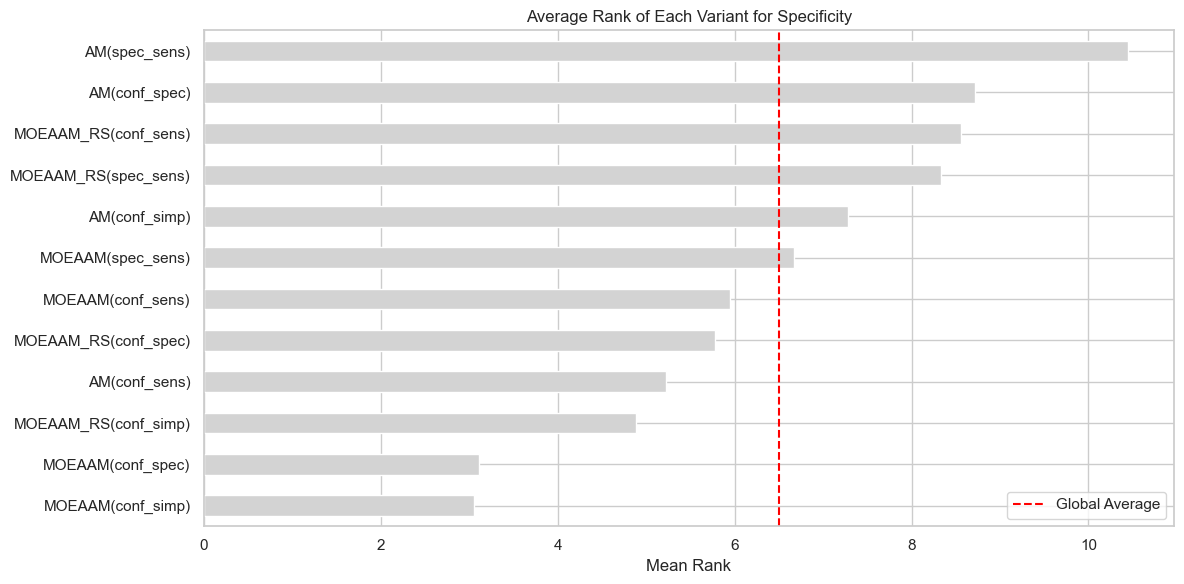

In [56]:
plot_avg_ranks(specificity_avg_ranks, "Specificity")

##### Friedman Tests

In [57]:
data = {
    "Accuracy": accuracy_dict,
    "F1 Score": f1_df,
    "Precision": precision_df,
    "Specificity": specificity_df
}

In [59]:
def friedman_test(data):
    results = []
    
    for metric, data in data.items():
        df = pd.DataFrame(data, index=DATASETS)
        
        stat, p_value = friedmanchisquare(*[df[col] for col in df.columns])
        
        results.append({
            "Metric": metric,
            "Chi-square Stat": stat,
            "P-value": p_value
        })
    
    return pd.DataFrame(results)

friedman_results = friedman_test(data)
friedman_results

,Metric,Chi-square Stat,P-value
0,Accuracy,6.103843,0.866346
1,F1 Score,11.140832,0.431541
2,Precision,22.367338,0.021677
3,Specificity,45.729560,0.000004


In [60]:
def wilcoxon_posthoc(df, p_threshold=0.05):

    algos = df.columns
    n = len(algos)
    p_matrix = pd.DataFrame(index=algos, columns=algos, dtype=float)
    
    print(f"{'='*10} Significant Pairs (p < {p_threshold}) {'='*10}")
    
    for i in range(n):
        for j in range(i + 1, n): 
            algo_a = algos[i]
            algo_b = algos[j]
            
            stat, p = wilcoxon(df[algo_a], df[algo_b], zero_method='zsplit')
            
            p_matrix.iloc[i, j], p_matrix.iloc[j, i] = p, p
            
            if p < p_threshold:
                print(f"{algo_a} and {algo_b}: p={p:.5f}")
    
    np.fill_diagonal(p_matrix.values, 1.0)
    return p_matrix

In [61]:
p_matrix = wilcoxon_posthoc(specificity_df)
p_matrix = p_matrix.map(lambda x: f"{x:.3f}")
p_matrix

========== Significant Pairs (p < 0.05) ==========
AM(spec_sens) and AM(conf_sens): p=0.00391
AM(spec_sens) and MOEAAM(conf_simp): p=0.00391
AM(spec_sens) and MOEAAM(conf_spec): p=0.00391
AM(spec_sens) and MOEAAM_RS(conf_simp): p=0.00391
AM(spec_sens) and MOEAAM_RS(conf_spec): p=0.01172
AM(conf_simp) and MOEAAM(conf_simp): p=0.01562
AM(conf_simp) and MOEAAM(conf_spec): p=0.03125
AM(conf_spec) and MOEAAM(conf_simp): p=0.00781
AM(conf_spec) and MOEAAM(conf_spec): p=0.00781
AM(conf_spec) and MOEAAM_RS(conf_simp): p=0.04688
AM(conf_spec) and MOEAAM_RS(conf_spec): p=0.01562
AM(conf_sens) and MOEAAM(spec_sens): p=0.04688
AM(conf_sens) and MOEAAM(conf_sens): p=0.04688
AM(conf_sens) and MOEAAM_RS(spec_sens): p=0.03125
AM(conf_sens) and MOEAAM_RS(conf_sens): p=0.03125
MOEAAM(spec_sens) and MOEAAM(conf_simp): p=0.03125
MOEAAM(spec_sens) and MOEAAM(conf_spec): p=0.04688
MOEAAM(spec_sens) and MOEAAM_RS(conf_sens): p=0.04688
MOEAAM(conf_simp) and MOEAAM(conf_sens): p=0.03125
MOEAAM(conf_simp) and M

,AM(spec_sens),AM(conf_simp),AM(conf_spec),AM(conf_sens),MOEAAM(spec_sens),MOEAAM(conf_simp),MOEAAM(conf_spec),MOEAAM(conf_sens),MOEAAM_RS(spec_sens),MOEAAM_RS(conf_simp),MOEAAM_RS(conf_spec),MOEAAM_RS(conf_sens)
AM(spec_sens),1.000,0.301,0.426,0.004,0.203,0.004,0.004,0.129,0.203,0.004,0.012,0.203
AM(conf_simp),0.301,1.000,0.148,0.328,0.953,0.016,0.031,0.867,0.773,0.188,0.180,0.867
AM(conf_spec),0.426,0.148,1.000,0.148,0.461,0.008,0.008,0.391,0.867,0.047,0.016,0.953
AM(conf_sens),0.004,0.328,0.148,1.000,0.047,0.266,0.266,0.047,0.031,0.453,0.609,0.031
MOEAAM(spec_sens),0.203,0.953,0.461,0.047,1.000,0.031,0.047,0.812,0.141,0.109,0.328,0.047
MOEAAM(conf_simp),0.004,0.016,0.008,0.266,0.031,1.000,0.875,0.031,0.016,0.031,0.031,0.016
MOEAAM(conf_spec),0.004,0.031,0.008,0.266,0.047,0.875,1.000,0.062,0.016,0.016,0.031,0.016
MOEAAM(conf_sens),0.129,0.867,0.391,0.047,0.812,0.031,0.062,1.000,0.016,0.328,0.453,0.016
MOEAAM_RS(spec_sens),0.203,0.773,0.867,0.031,0.141,0.016,0.016,0.016,1.000,0.016,0.141,0.781
MOEAAM_RS(conf_simp),0.004,0.188,0.047,0.453,0.109,0.031,0.016,0.328,0.016,1.000,0.266,0.016


##### Specific Friedman Tests

In [ ]:
combinations = [
    ("AM", "spec_sens"),
    ("MOEAAM", "spec_sens"),
    ("MOEAAM_RS", "spec_sens")
]

f1_custom_dict = extract_specific_means(dfs, combinations, target_metric="accuracy")
f1_custom_df = pd.DataFrame(f1_custom_dict, index=DATASETS)
f1_custom_ranks, f1_custom_avg_ranks = get_ranking(f1_custom_df)
f1_custom_ranks

,AM(spec_sens),MOEAAM(spec_sens),MOEAAM_RS(spec_sens)
mushrooms,93.26 (1),86.28 (3),87.81 (2)
cargood,96.26 (1),93.53 (3),93.91 (2)
chess,97.11 (1),96.61 (3),96.99 (2)
zoo3,90.32 (3),90.34 (1.5),90.34 (1.5)
flare,93.95 (1),93.06 (2),92.42 (3)
yeast3,84.48 (3),88.92 (1),88.67 (2)
abalone19,97.43 (2),97.43 (2),97.43 (2)
segment0,93.86 (2),93.63 (3),95.38 (1)
pageblocks,80.99 (2),79.32 (3),81.56 (1)
Average Rank,1.778,2.389,1.833


In [67]:
data_custom = {
    "F1 Score": f1_custom_df
}
friedman_custom_results = friedman_test(data_custom)
friedman_custom_results

,Metric,Chi-square Stat,P-value
0,F1 Score,2.387097,0.303144


In [28]:
p_matrix = wilcoxon_posthoc(f1_df, p_threshold=0.09)
p_matrix = p_matrix.map(lambda x: f"{x:.3f}")
p_matrix

========== Significant Pairs (p < 0.09) ==========
AM(spec_sens) and AM(conf_sens): p=0.08398
AM(conf_spec) and AM(conf_sens): p=0.05469
AM(conf_sens) and MOEAAM_RS(conf_spec): p=0.08398


,AM(spec_sens),AM(conf_simp),AM(conf_spec),AM(conf_sens),MOEAAM(spec_sens),MOEAAM(conf_simp),MOEAAM(conf_spec),MOEAAM(conf_sens),MOEAAM_RS(spec_sens),MOEAAM_RS(conf_simp),MOEAAM_RS(conf_spec),MOEAAM_RS(conf_sens)
AM(spec_sens),1.000,0.970,0.301,0.084,0.218,0.705,0.820,0.359,0.544,0.595,0.705,0.493
AM(conf_simp),0.970,1.000,0.283,0.218,0.101,0.140,0.595,0.101,0.311,0.101,0.649,0.401
AM(conf_spec),0.301,0.283,1.000,0.055,0.163,0.119,0.319,0.163,0.218,0.140,0.101,0.281
AM(conf_sens),0.084,0.218,0.055,1.000,1.000,0.596,0.100,0.541,0.703,0.412,0.084,0.596
MOEAAM(spec_sens),0.218,0.101,0.163,1.000,1.000,0.541,0.648,0.648,0.117,0.879,0.611,0.117
MOEAAM(conf_simp),0.705,0.140,0.119,0.596,0.541,1.000,0.762,0.648,0.223,0.162,0.162,0.217
MOEAAM(conf_spec),0.820,0.595,0.319,0.100,0.648,0.762,1.000,0.633,0.703,0.984,0.648,0.703
MOEAAM(conf_sens),0.359,0.101,0.163,0.541,0.648,0.648,0.633,1.000,0.217,0.703,0.762,0.162
MOEAAM_RS(spec_sens),0.544,0.311,0.218,0.703,0.117,0.223,0.703,0.217,1.000,0.939,1.000,0.596
MOEAAM_RS(conf_simp),0.595,0.101,0.140,0.412,0.879,0.162,0.984,0.703,0.939,1.000,0.400,0.662


##### Classical Classification Algorithms

In [29]:
DATASETS_PATH = "../../datasets/SLC/"
def calculate_metrics(y_true, y_pred):

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    
    cm = confusion_matrix(y_true, y_pred)
    
    if cm.shape == (2, 2):

        tn, fp, _, _ = cm.ravel()
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    return {
        "accuracy": acc * 100,
        "f1_score": f1 * 100,
        "recall": rec * 100,
        "precision": prec * 100,
        "specificity": spec * 100
    }

In [30]:
def get_baseline_results(datasets):
    baseline_data = []
    
    print(f"Running Training (RIPPER, C4.5, CS-C4.5)...")
    print("-" * 60)

    for ds in datasets:
        path = os.path.join(DATASETS_PATH, f"{ds}.csv")
        if not os.path.exists(path):
            path = path.replace(".csv", ".data")
        
        if not os.path.exists(path):
            continue

        try:
            df = pd.read_csv(path)
            df.columns = df.columns.str.strip()
            if 'class' not in df.columns: continue
            
            y = LabelEncoder().fit_transform(df['class'])
            X = pd.get_dummies(df.drop('class', axis=1)).values
        except:
            continue

        n_folds = min(5, len(y))
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
        
        algos = ["C4.5", "CS-C4.5", "RIPPER"]
        fold_results = {algo: {m: [] for m in ["accuracy", "f1_score", "recall", "precision", "specificity"]} for algo in algos}
        
        models = {
            "C4.5": DecisionTreeClassifier(criterion='entropy', random_state=42),
            "CS-C4.5": DecisionTreeClassifier(criterion='entropy', class_weight='balanced', random_state=42),
            "RIPPER": lw.RIPPER(random_state=42)
        }

        print(f"Running {ds}...")

        for train_idx, test_idx in skf.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            for name, model in models.items():
                try:
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                    
                    metrics = calculate_metrics(y_test, y_pred)
                    
                    for m_name, m_val in metrics.items():
                        fold_results[name][m_name].append(m_val)
                except:
                    pass

        for name in algos:
            row = {"Dataset": ds, "Algorithm": name}
            for m in ["accuracy", "f1_score", "recall", "precision", "specificity"]:
                vals = fold_results[name][m]
                row[m] = np.mean(vals) if vals else 0.0
            
            baseline_data.append(row)

    return pd.DataFrame(baseline_data)

In [31]:
df_baselines = get_baseline_results(DATASETS)

Running Training (RIPPER, C4.5, CS-C4.5)...
------------------------------------------------------------
Running mushrooms...
Running tictactoe...
Running hepatitis...
Running ljubljana...
Running cargood...
Running chess...
Running zoo3...
Running flare...
Running yeast3...
Running abalone19...
Running segment0...
Running pageblocks...


In [32]:
df_baselines
#df_baselines.to_csv(os.path.join(SAVE_DIR, "baseline_results.csv"), index=False)

,Dataset,Algorithm,accuracy,f1_score,recall,precision,specificity
0,mushrooms,C4.5,100.000000,100.000000,100.000000,100.000000,100.000000
1,mushrooms,CS-C4.5,100.000000,100.000000,100.000000,100.000000,100.000000
2,mushrooms,RIPPER,100.000000,100.000000,100.000000,100.000000,100.000000
3,tictactoe,C4.5,93.636562,92.949274,92.871786,93.096774,90.370873
4,tictactoe,CS-C4.5,93.530214,92.902734,93.211831,92.648460,92.170963
5,tictactoe,RIPPER,98.954516,98.831924,98.629149,99.079397,97.575758
6,hepatitis,C4.5,72.903226,63.246444,65.938095,62.927345,78.066667
7,hepatitis,CS-C4.5,77.419355,65.747316,66.697619,65.536358,85.300000
8,hepatitis,RIPPER,80.645161,69.107614,67.192857,73.268787,90.100000
9,ljubljana,C4.5,64.680135,57.730312,58.091857,57.715085,74.345479


In [33]:
def compare_best(baseline_df, user_results_dict, datasets, metric="f1_score"):
    comparison_rows = []
    
    print(f"\n{'Dataset':<15} | {'Best Algo':<25} | {metric + ' %':<6}")
    print("-" * 80)
    
    for ds in datasets:

        ds_base = baseline_df[baseline_df['Dataset'] == ds]
        
        if not ds_base.empty:
            best_base_row = ds_base.loc[ds_base[metric].idxmax()]
            best_base_name = best_base_row['Algorithm']
            best_base_f1 = best_base_row[metric]
            best_base_acc = best_base_row['accuracy']
        else:
            best_base_name, best_base_f1, best_base_acc = "None", 0, 0

        best_user_name = "None"
        best_user_f1 = 0
        best_user_acc = 0
        
        if ds in user_results_dict and 'mean' in user_results_dict[ds]:
            df_user = user_results_dict[ds]['mean']
            if not df_user.empty:
                try:
                    test_df = df_user.xs('test', level='Split')
                    
                    if metric in test_df.columns:
                        idx_best = test_df[metric].idxmax()
                        
                        best_user_f1 = test_df.loc[idx_best, metric]
                        best_user_acc = test_df.loc[idx_best, 'accuracy']
                        best_user_name = f"{idx_best[0]} ({idx_best[1]})"
                except:
                    pass

        if best_user_f1 >= best_base_f1:
            winner = best_user_name
            win_f1 = best_user_f1
        else:
            winner = best_base_name
            win_f1 = best_base_f1
            
        print(f"{ds:<15} | {winner:<25} | {win_f1:.2f}")
        
        comparison_rows.append({
            "Dataset": ds,
            "Best_Algo": winner,
            metric: win_f1,
        })

    return pd.DataFrame(comparison_rows)

In [ ]:
leaderboard = compare_best(df_baselines, dfs, DATASETS, metric="specificity")


Dataset         | Best Algo                 | specificity %
--------------------------------------------------------------------------------
mushrooms       | MOEAAM (conf_simp)        | 100.00
cargood         | AM (conf_sens)            | 99.84
chess           | MOEAAM (conf_simp)        | 100.00
zoo3            | AM (conf_simp)            | 100.00
flare           | MOEAAM (spec_sens)        | 99.86
yeast3          | AM (conf_sens)            | 99.27
abalone19       | AM (conf_sens)            | 100.00
segment0        | MOEAAM (conf_simp)        | 99.92
pageblocks      | MOEAAM (conf_simp)        | 99.70
